<a href="https://colab.research.google.com/github/mar25-iia2-radiographies/mar25_radiographies_pulmonaires_covid19/blob/main/notebooks/02_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Préambule

Dans le premier notebook d’exploration, plusieurs points clés ont été mis en évidence : les images sont déjà en niveaux de gris et de taille 299×299, mais la distribution des intensités présente des valeurs extrêmes (images très sombres ou très claires), et les classes sont fortement déséquilibrées. Avant d’entraîner un modèle de classification, il est donc nécessaire de mettre en place un preprocessing capable à la fois de corriger ces anomalies de contraste et de réduire l’impact des différences d’acquisition entre images.

Dans ce second notebook, les outliers ne seront pas traités d’emblée comme des candidats à l’exclusion, mais comme des candidats à la **correction de contraste**. L’idée est d’utiliser des techniques d’égalisation d’histogramme (globale et adaptative) pour “ramener” les images très sombres ou très claires dans une plage d’intensité plus comparable au reste du dataset, puis d’évaluer si ces corrections suffisent à régulariser leur distribution de pixels au sein de chaque catégorie.

En parallèle, le notebook explorera l’impact de **masques pulmonaires** appliqués sur les radiographies. L’objectif est de vérifier si le fait de restreindre l’analyse aux seules régions pulmonaires permet de stabiliser la distribution des intensités par classe, en supprimant des zones non pertinentes (clavicules, cœur, annotations, bords de champ). Deux logiques seront envisagées :  
- une approche **end-to-end**, où le modèle est entraîné directement sur les images brutes sans masque explicite,  
- une approche **avec segmentation automatique**, dans laquelle un masque de poumon généré par un segmentateur (par exemple de type U-Net) est appliqué en amont pour isoler la zone d’intérêt.  

Tester ces deux scénarios permet de répondre à une question centrale de preprocessing : jusqu’à quel point est-il utile de contraindre le modèle à se focaliser explicitement sur les poumons (via un masque) pour régulariser la distribution des pixels et réduire les artefacts, et dans quels cas une simple normalisation globale (avec ou sans égalisation d’histogramme) est suffisante pour obtenir des performances robustes en classification.

NOTEBOOK 02 - SECTION 2 : RECHARGEMENT + DÉTECTION OUTLIERS


100%|██████████| 778M/778M [00:08<00:00, 91.7MB/s]

Extracting files...


✅ Dataset chargé : /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5
📁 data_path : /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset

🔄 Construction df_total (filepath + category)...
  COVID           :  3,616 images
  Normal          : 10,192 images
  Lung_Opacity    :  6,012 images
  Viral Pneumonia :  1,345 images

🎯 df_total créé : 21,165 images
Aperçu :
                                            filepath category
0  /root/.cache/kagglehub/datasets/tawsifurrahman...    COVID
1  /root/.cache/kagglehub/datasets/tawsifurrahman...    COVID
2  /root/.cache/kagglehub/datasets/tawsifurrahman...    COVID
3  /root/.cache/kagglehub/datasets/tawsifurrahman...    COVID
4  /root/.cache/kagglehub/datasets/tawsifurrahman...    COVID

🔍 Calcul intensité moyenne pour détection outliers...

📊 SEUILS DÉTECTION OUTLIERS :
   Bas : mean < 75 (sombres)
   Haut: mean > 175 (claires)

COMPTES PAR CATÉGO

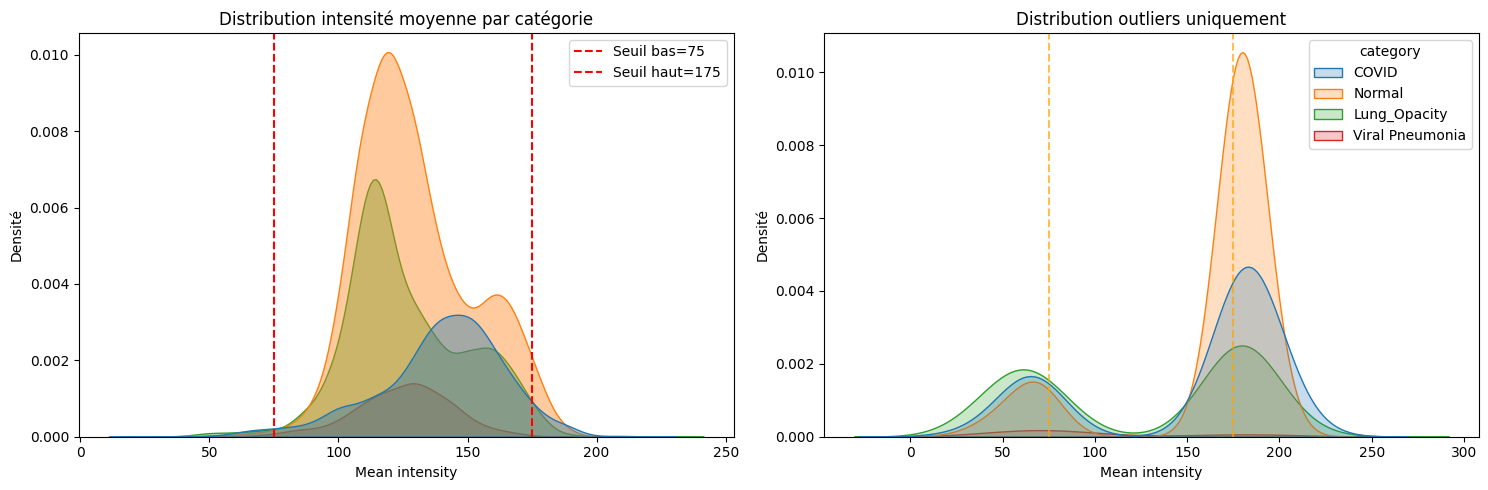


✅ SECTION 2 TERMINÉE
df_total prêt avec colonnes : 'filepath', 'category', 'mean_intensity', 'is_outlier'
Prochaine étape : Correction outliers par equalization (Section 3)


In [1]:
import kagglehub
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("NOTEBOOK 02 - SECTION 2 : RECHARGEMENT + DÉTECTION OUTLIERS")
print("="*80)

# 2.1 Rechargement dataset via kagglehub
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
base_path = Path(path)
data_path = base_path / "COVID-19_Radiography_Dataset"
categories = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

print(f"✅ Dataset chargé : {base_path}")
print(f"📁 data_path : {data_path}")

# 2.2 Construction df_total (filepath + category)
print("\n🔄 Construction df_total (filepath + category)...")
records = []

for cat in categories:
    cat_path = data_path / cat / 'images'
    image_paths = list(cat_path.glob('*.png'))
    print(f"  {cat:15} : {len(image_paths):>6,} images")

    for img_path in image_paths:
        records.append({
            'filepath': str(img_path),
            'category': cat
        })

df_total = pd.DataFrame(records)
print(f"\n🎯 df_total créé : {len(df_total):,} images")
print("Aperçu :")
print(df_total.head())

# 2.3 Détection outliers (PAS suppression) : mean <75 ou >175
print("\n🔍 Calcul intensité moyenne pour détection outliers...")
df_total['mean_intensity'] = np.nan

for idx, row in df_total.iterrows():
    try:
        img = Image.open(row['filepath']).convert('L')
        mean_val = np.array(img).mean()
        df_total.at[idx, 'mean_intensity'] = mean_val
    except:
        continue

# Seuils notebook 01
low_thresh, high_thresh = 75, 175
df_total['is_outlier'] = (df_total['mean_intensity'] < low_thresh) | \
                         (df_total['mean_intensity'] > high_thresh)

print(f"\n📊 SEUILS DÉTECTION OUTLIERS :")
print(f"   Bas : mean < {low_thresh} (sombres)")
print(f"   Haut: mean > {high_thresh} (claires)")

# 2.4 Comptes AVANT/APRÈS identification outliers par catégorie
print("\n" + "="*50)
print("COMPTES PAR CATÉGORIE")
print("="*50)

counts_total = df_total['category'].value_counts().sort_index()
counts_outliers = df_total[df_total['is_outlier']]['category'].value_counts().sort_index()
counts_normal = df_total[~df_total['is_outlier']]['category'].value_counts().sort_index()

summary_df = pd.DataFrame({
    'Total': counts_total,
    'Outliers': counts_outliers.reindex(counts_total.index, fill_value=0),
    '% Outliers': (counts_outliers.reindex(counts_total.index, fill_value=0) / counts_total * 100).round(1)
}).fillna(0)

print(summary_df)

total_outliers = df_total['is_outlier'].sum()
print(f"\n🎯 TOTAL OUTLIERS DÉTECTÉS : {total_outliers:,} ({total_outliers/len(df_total)*100:.1f}%)")

# 2.5 Visualisation distribution mean par classe (KDE + outliers marqués)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.kdeplot(data=df_total, x='mean_intensity', hue='category', fill=True, alpha=0.4)
plt.axvline(low_thresh, color='red', linestyle='--', label=f'Seuil bas={low_thresh}')
plt.axvline(high_thresh, color='red', linestyle='--', label=f'Seuil haut={high_thresh}')
plt.title('Distribution intensité moyenne par catégorie')
plt.xlabel('Mean intensity')
plt.ylabel('Densité')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_total[df_total['is_outlier']], x='mean_intensity', hue='category', fill=True)
plt.axvline(low_thresh, color='orange', linestyle='--', alpha=0.7)
plt.axvline(high_thresh, color='orange', linestyle='--', alpha=0.7)
plt.title('Distribution outliers uniquement')
plt.xlabel('Mean intensity')
plt.ylabel('Densité')

plt.tight_layout()
plt.show()

print("\n✅ SECTION 2 TERMINÉE")
print("df_total prêt avec colonnes : 'filepath', 'category', 'mean_intensity', 'is_outlier'")
print("Prochaine étape : Correction outliers par equalization (Section 3)")


L’analyse des distributions d’intensité moyenne par catégorie montre que la plupart des images se situent dans une plage relativement compacte, centrée approximativement entre 100 et 160 en niveaux de gris, toutes classes confondues. Les seuils initiaux fixés à 75 et 175 avaient été choisis de manière heuristique dans le premier notebook, sans visualisation fine des courbes de densité. Le graphique met cependant en évidence que ces valeurs ne correspondent pas parfaitement à la structure réelle du dataset.​

En particulier, le seuil bas à 75 coupe déjà le bas de la bosse principale, ce qui risque de marquer comme « outliers » des images simplement un peu plus sombres mais encore plausibles. À l’inverse, le seuil haut à 175 intersecte une partie notable de la distribution des images normales et COVID, qui apparaissent seulement légèrement plus claires, sans être nécessairement aberrantes. Pour que l’étiquette d’outlier garde un sens fort, il est préférable de cibler uniquement les queues extrêmes des distributions, c’est‑à‑dire des images vraiment atypiques par leur luminosité. C’est pourquoi les seuils vont être ajustés de façon plus conservatrice, en élargissant la plage « normale » et en ne marquant comme outliers que les images très sombres ou très claires, qui seront ensuite corrigées par equalization / CLAHE plutôt que supprimées.


RÉSUMÉ APRÈS NOUVEAUX SEUILS :
                 Total  Outliers  % Outliers
category                                    
COVID             3616        56         1.5
Lung_Opacity      6012        60         1.0
Normal           10192        33         0.3
Viral Pneumonia   1345         2         0.1


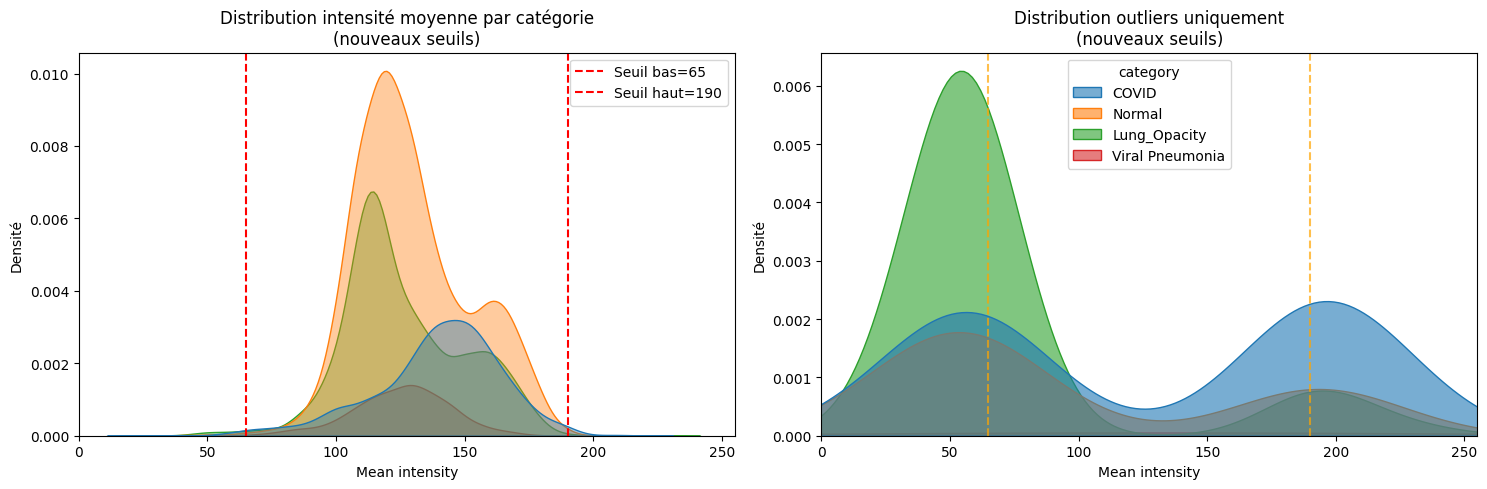

In [4]:
# Recalcul des outliers avec les nouveaux seuils
low_thresh  = 65
high_thresh = 190

df_total['is_outlier'] = (df_total['mean_intensity'] < low_thresh) | \
                         (df_total['mean_intensity'] > high_thresh)

# Récap après nouveaux seuils
counts_total = df_total['category'].value_counts().sort_index()
counts_outliers = df_total[df_total['is_outlier']]['category'].value_counts().sort_index()

summary_df = pd.DataFrame({
    'Total': counts_total,
    'Outliers': counts_outliers.reindex(counts_total.index, fill_value=0),
    '% Outliers': (counts_outliers.reindex(counts_total.index, fill_value=0) / counts_total * 100).round(1)
}).fillna(0)

print("\nRÉSUMÉ APRÈS NOUVEAUX SEUILS :")
print(summary_df)

# Nouveau graphique KDE avec seuils 65 / 190
plt.figure(figsize=(15, 5))

# 1) Toutes les images
plt.subplot(1, 2, 1)
sns.kdeplot(data=df_total, x='mean_intensity', hue='category', fill=True, alpha=0.4)
plt.axvline(low_thresh, color='red', linestyle='--', label=f'Seuil bas={low_thresh}')
plt.axvline(high_thresh, color='red', linestyle='--', label=f'Seuil haut={high_thresh}')
plt.title('Distribution intensité moyenne par catégorie\n(nouveaux seuils)')
plt.xlabel('Mean intensity')
plt.ylabel('Densité')
plt.xlim(0, 255)  # ← plage complète des niveaux de gris
plt.legend()

# 2) Outliers uniquement
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_total[df_total['is_outlier']], x='mean_intensity', hue='category', fill=True, alpha=0.6)
plt.axvline(low_thresh, color='orange', linestyle='--', alpha=0.7)
plt.axvline(high_thresh, color='orange', linestyle='--', alpha=0.7)
plt.title('Distribution outliers uniquement\n(nouveaux seuils)')
plt.xlabel('Mean intensity')
plt.ylabel('Densité')
plt.xlim(0, 255)  # ← pareil ici pour cohérence

plt.tight_layout()
plt.show()



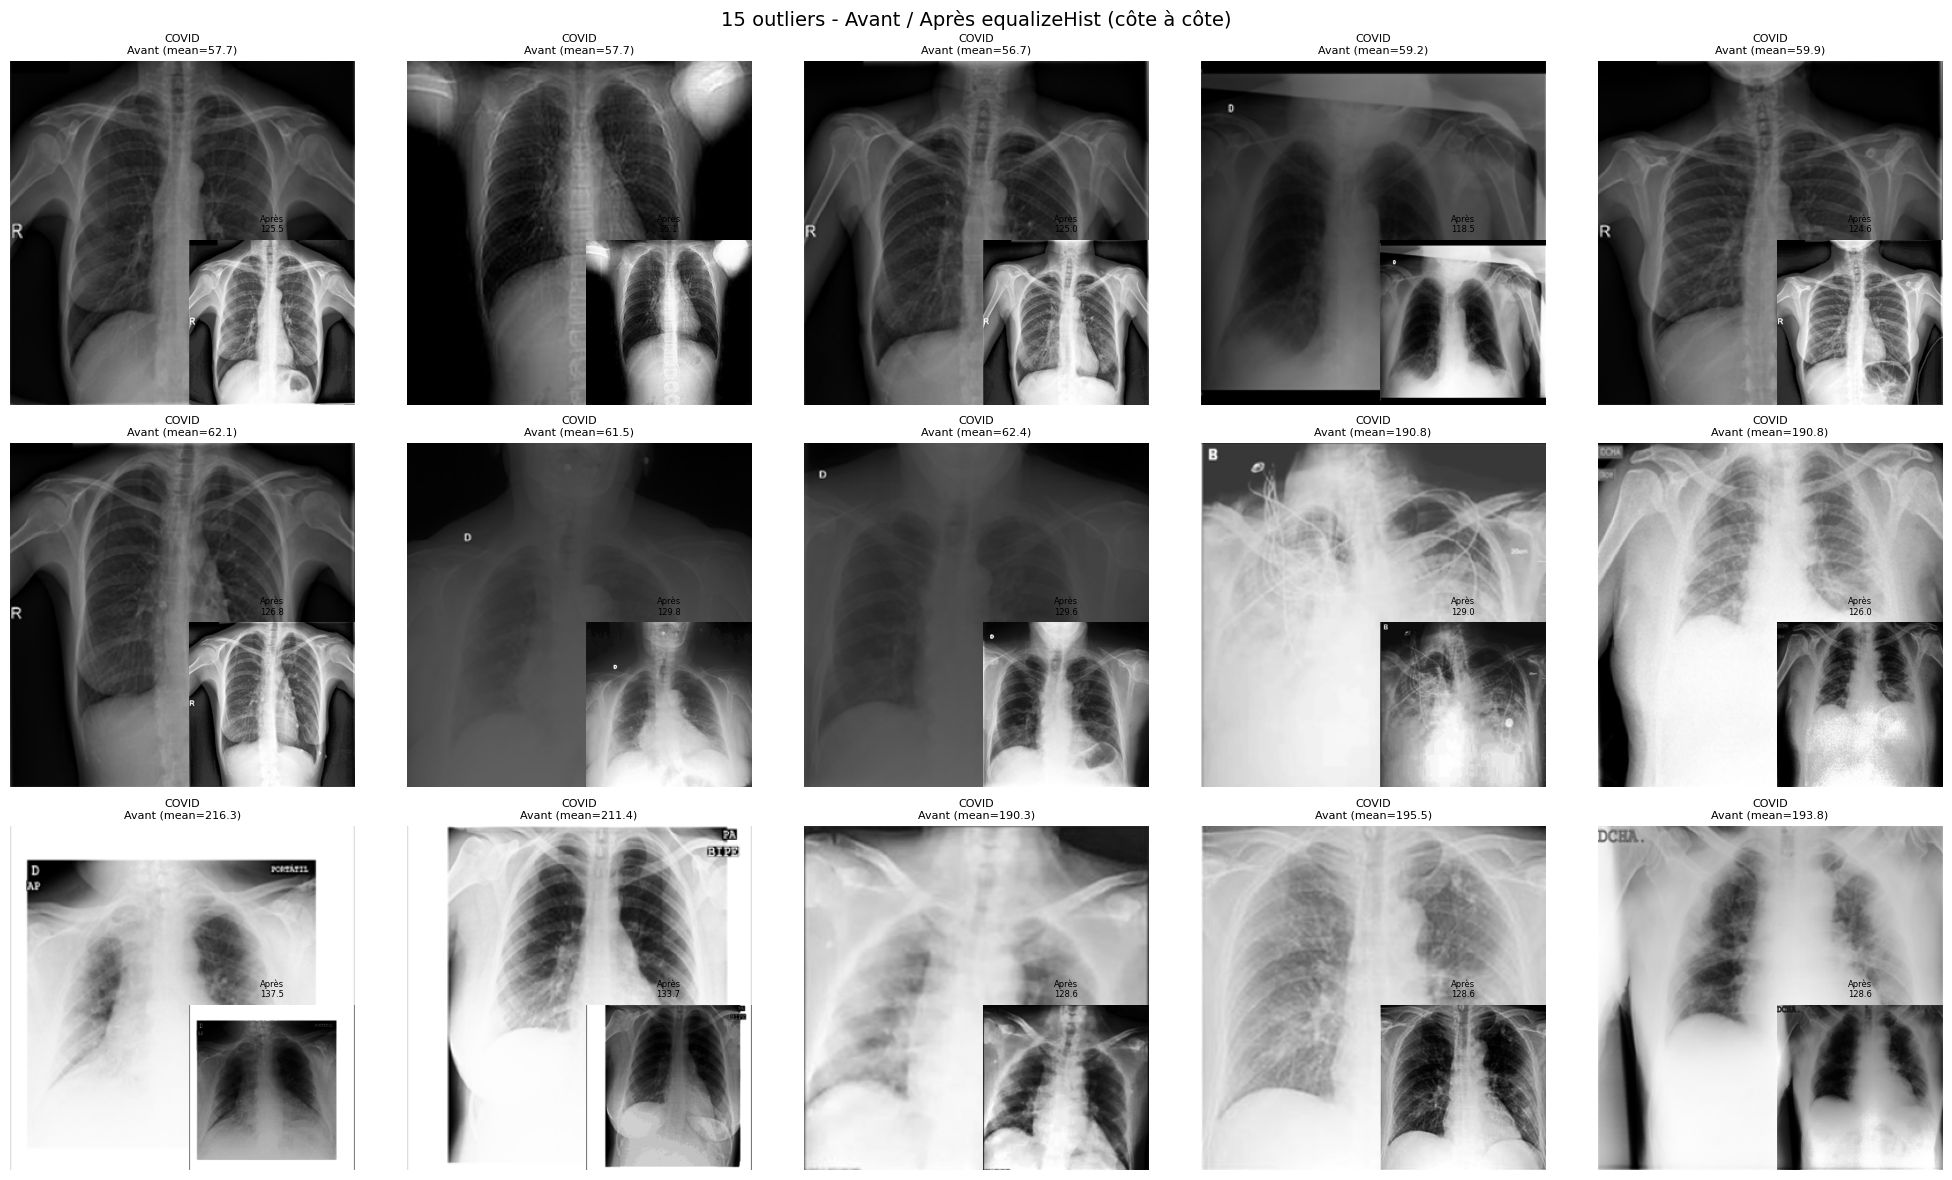

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

low_thresh  = 65
high_thresh = 190

def correct_equalize(img_path):
    img = Image.open(img_path).convert('L')
    arr = np.array(img, dtype=np.uint8)
    equ = cv2.equalizeHist(arr)
    equ_norm = equ.astype(np.float32) / 255.0
    return arr, equ_norm

# Sélection 15 outliers (sombres + clairs)
outliers_low  = df_total[df_total['mean_intensity'] < low_thresh].head(8)
outliers_high = df_total[df_total['mean_intensity'] > high_thresh].head(7)
outliers_sample = pd.concat([outliers_low, outliers_high], ignore_index=True).head(15)

rows, cols = 3, 5
plt.figure(figsize=(4 * cols, 4 * rows))

for i, (_, row) in enumerate(outliers_sample.iterrows()):
    img_path = row['filepath']
    cat = row['category']

    orig_uint8, equ_norm = correct_equalize(img_path)
    mean_before = orig_uint8.mean()
    mean_after  = (equ_norm * 255).mean()

    # Avant
    ax1 = plt.subplot(rows, cols, i + 1)
    ax1.imshow(orig_uint8, cmap='gray', vmin=0, vmax=255)
    ax1.set_title(f"{cat}\nAvant (mean={mean_before:.1f})", fontsize=8)
    ax1.axis('off')

    # Après juste à droite (via inset_axes)
    ax2 = ax1.inset_axes([0.52, 0.0, 0.48, 0.48])
    ax2.imshow(equ_norm, cmap='gray', vmin=0, vmax=1)
    ax2.set_title(f"Après\n{mean_after:.1f}", fontsize=6)
    ax2.axis('off')

plt.suptitle("15 outliers - Avant / Après equalizeHist (côte à côte)", fontsize=14)
plt.tight_layout()
plt.show()



